# Imports and model initialization

In [20]:
%load_ext autoreload
%autoreload 2
# !pip install kipoi
# !pip install kipoiseq
# !pip install pybedtools
# !pip uninstall -y kipoi_veff
# !pip install git+https://github.com/an1lam/kipoi-veff
# !pip install pyvcf
import csv
import math
import pickle

from Bio.motifs import pfm
from Bio.motifs.jaspar import calculate_pseudocounts
import kipoi
from kipoi_interpret.importance_scores.ism import Mutation
from kipoiseq.dataloaders import SeqIntervalDl
from logomaker import Logo
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import cm
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
from tqdm import tqdm

from align import prob_sw
from motif_scores import build_impact_maps
from motif_scores import kmer_mut_scores
from motif_scores import kmer_pwm_scores
from motif_scores import pwm_scores
from motif_scores import top_n_kmer_mut_scores
from motif_scores import top_n_kmer_pwm_scores
from np_utils import abs_max
from pyx.one_hot import one_hot
from utils import BASES
from utils import INT_TO_BASES
from utils import one_hot_decode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
!pwd

/home/stephenmalina/project/src


# Loading DNA sequence data

In [22]:
dl = SeqIntervalDl("../dat/50_random_seqs_2.bed", "../dat/hg19.fa", auto_resize_len=1000)
data = dl.load_all()

100%|██████████| 2/2 [00:00<00:00, 38.76it/s]


In [23]:
seqs = np.expand_dims(data['inputs'].transpose(0, 2, 1), 2).astype(np.float32)
seqs.shape

(50, 4, 1, 1000)

# Loading DeepSEA

In [24]:
import tensorflow as tf
print("TF version:", tf.__version__)
import torch
print("torch version:", torch.__version__)
from torch import nn
from torch.nn import functional as F

TF version: 1.15.0
torch version: 1.3.1


In [25]:
# df = kipoi.list_models()
# deepsea_models = df[df.model.str.contains("DeepSEA")]
# deepsea_models.head()

In [26]:
deepsea = kipoi.get_model("DeepSEA/predict", source="kipoi")
deepsea.model

Using downloaded and verified file: /home/stephenmalina/.kipoi/models/DeepSEA/predict/downloaded/model_files/weights/89e640bf6bdbe1ff165f484d9796efc7


Sequential(
  (0): ReCodeAlphabet()
  (1): ConcatenateRC()
  (2): Sequential(
    (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
    (1): Threshold(threshold=0, value=1e-06)
    (2): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
    (5): Threshold(threshold=0, value=1e-06)
    (6): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(480, 960, kernel_size=(1, 8), stride=(1, 1))
    (9): Threshold(threshold=0, value=1e-06)
    (10): Dropout(p=0.5, inplace=False)
    (11): Lambda()
    (12): Sequential(
      (0): Lambda()
      (1): Linear(in_features=50880, out_features=925, bias=True)
    )
    (13): Threshold(threshold=0, value=1e-06)
    (14): Sequential(
      (0): Lambda()
      (1): Linear(in_features=925, out_features=919, bias=True)
    )
    (15):

In [27]:
CHROM_ACC_COL = 'HepG2_DNase_None'
# TF_COL = 'A549_CTCF_None'
TF_COL = 'HepG2_FOXA1_None'
relevant_cols = sorted([(i, label)
                        for i, label in enumerate(deepsea.schema.targets.column_labels)
                        if label in [CHROM_ACC_COL, TF_COL]])

In [28]:
deepsea.pipeline.predict_example().shape

100%|██████████| 1/1 [00:00<00:00, 24.56it/s]


(10, 919)

# Loading Predictions

In [29]:
import pickle
# pickle_file = "../dat/most_recent_sat_mut_results__drop_channel.pickle"
pickle_file = "../dat/most_recent_sat_mut_results__original_mc_dropout.pickle"

In [30]:
with open(pickle_file, 'rb') as f: np_preds = pickle.load(f)
print(np_preds.shape)
epochs, n_seqs, n_batches, batch_size, _ = np_preds.shape
np_preds.shape

(50, 50, 10, 301, 3)


(50, 50, 10, 301, 3)

In [31]:
all_zeros = np.zeros((4,))

def batches_needed(seq_len, batch_size, alpha_size=4):
    assert ((seq_len * (alpha_size-1)) % (batch_size-1)) == 0, seq_len * 3
    # alpha_size - 1 mutations per nt and then account for ref in each batch
    return (seq_len * (alpha_size-1)) // (batch_size-1)

def generate_wt_mut_batches(seq, batch_size=None, context_size=None):
    """
    For a given sequence, generate all possible point-mutated versions of the sequence
    in batches of size `param:batch_size`.
    
    Args:
        seq (numpy.ndarray [number of base pairs, sequence length]): 
            wild type sequence.
        batch_size (int): size of returned batches. Note that each batch will have the
            wild type sequence as its first row since we need to compute wild type / mut
            prediction diffs using predictions generated by the same dropout mask.
    """
    num_nts, seq_len = seq.shape
    if batch_size is None: batch_size = (num_nts-1) * seq_len + 1
    n_batches = batches_needed(seq_len, batch_size, alpha_size=num_nts)
    new_seq_len = context_size if context_size is not None else seq_len
    seq_batches = np.zeros((n_batches, batch_size, num_nts, new_seq_len))    
    if context_size is not None:
        seq_batches = np.zeros((n_batches, batch_size, num_nts, context_size * 2 + 1, ))
        
    i = 0
    for seq_idx in range(seq_len):  # iterate over sequence 
        for nt_idx in range(num_nts):  # iterate over nucleotides
            curr_batch, curr_idx = i // (batch_size - 1), (i % (batch_size-1) + 1)
            seq_ = seq.copy()
            curr_nt = seq[nt_idx, seq_idx]
            if curr_nt == 1: continue
            start_idx, end_idx = (0, seq_len)
            if context_size is not None:
                start_idx, end_idx = max(seq_idx - context_size, 0), min(seq_idx + context_size + 1, seq_len)
            curr_mut = seq_batches[curr_batch, curr_idx]
            curr_mut[nt_idx, context_size] = 1
            extend_back, extend_forwards = seq_idx - start_idx, end_idx - seq_idx
            curr_mut[:, context_size - extend_back:context_size] = seq_[:, start_idx: seq_idx]
            curr_mut[:, context_size + 1: context_size + extend_forwards] = seq_[:, seq_idx+1: end_idx]
            i += 1
    return seq_batches

In [32]:
def next_seq(it):
    return (np
            .expand_dims(next(it)["inputs"].transpose(0, 2, 1), 2)
            .astype(np.float32)
            .squeeze())

In [33]:
epochs, n_seqs, batch_size = 50, 25, 301
n_nts, _, seq_len = deepsea.schema.inputs.shape
preds = [[[] for _ in range(n_seqs)] for _ in range(epochs)]
it = dl.batch_iter(batch_size=1, num_workers=0, drop_last=False)

print(f"Generating predictions for {len(it)} seqs")
n_batches = batches_needed(seq_len, batch_size, alpha_size=n_nts)
seqs = np.zeros((n_seqs, n_nts, seq_len))
batch_size = 301
for i in tqdm(range(min(n_seqs, len(it)))):
    seq = next_seq(it)
    if np.allclose(seq, .25): raise Exception("shouldn't have empty seqs")
    seqs[i, :, :] = seq

Generating predictions for 50 seqs


100%|██████████| 25/25 [00:00<00:00, 762.60it/s]


# Loading known FOXA1 motifs

In [34]:
with open('../dat/foxa1.pfm') as f: foxa1_motifs = pfm.read(f, 'pfm-four-rows')

In [36]:
def bio_to_np_pwm(motif):
    nt_counts = motif.counts
    motif_len = len(list(nt_counts.values())[0])
    pseudocounts = calculate_pseudocounts(motif)
    
    np_pwm = np.zeros((len(nt_counts.keys()), motif_len))
    for i in range(motif_len):
        total = sum(nt_counts[base][i] + pseudocounts[base] for base in BASES)
        for j, base in INT_TO_BASES.items(): 
            np_pwm[j, i] = (nt_counts[base][i] + pseudocounts[base]) / total 
    return np.log(np_pwm)
        
foxa1_pwms = [bio_to_np_pwm(motif) for motif in foxa1_motifs]

In [37]:
calculate_pseudocounts(foxa1_motifs[3])

{'G': 142.0393871431442,
 'A': 142.0393871431442,
 'T': 142.0393871431442,
 'C': 142.0393871431442}

(0, 2)

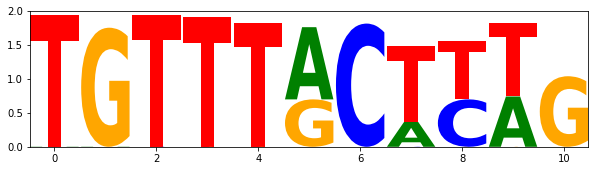

In [38]:
logo = Logo(pd.DataFrame(np.log2((np.exp(foxa1_pwms[0])) / .25).T, columns=BASES))
logo.ax.set_ylim([0, 2])

# Results & Analysis
## Computing summary statistics

In [39]:
log_uniform_prob = math.log(.05/(1-.05))
def compute_normalized_prob(prob, train_prob):
    # source: http://deepsea.princeton.edu/help/
    denom = 1+np.exp(-(np.log(prob/(1-prob))+log_uniform_prob-np.log(train_prob/(1-train_prob))))
    return 1 / denom

# Ratios and normalization formula drawn from here: http://deepsea.princeton.edu/media/help/posproportion.txt
tf_compute_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.02394)
chrom_acc_normalized_prob = lambda prob: compute_normalized_prob(prob, 0.049791)

In [40]:
np_preds[:, :, :, :, 0] = chrom_acc_normalized_prob(np_preds[:, :, :, :, 0])
np_preds[:, :, :, :, 1] = compute_normalized_prob(np_preds[:, :, :, :, 1], 0.020508)
np_preds[:, :, :, :, 2] = compute_normalized_prob(np_preds[:, :, :, :, 2], 0.02394)

In [41]:
n_batches = np_preds.shape[2]
batch_size = np_preds.shape[3]
np_preds.shape

(50, 50, 10, 301, 3)

In [42]:
np_pred_means = np.mean(np_preds[:, :, :, :, :], axis=0)
np_pred_vars = np.var(np_preds, axis=0, dtype=np.float64)
np_pred_means.shape

(50, 10, 301, 3)

In [43]:
np_pred_mean_diffs = np_pred_means[:, :, 1:, :] - np_pred_means[:, :, 0:1, :] 
np_pred_mean_diffs.shape

(50, 10, 300, 3)

In [44]:
np_logo_mean_refs = np_pred_means[:, :, 0:1, 1].reshape(np_pred_means.shape[0], 1, -1)
np_logo_mean_refs = np_logo_mean_refs.repeat(seq_len // n_batches, axis=2)
np_logo_mean_muts = np_pred_means[:, :, 1:, 1].reshape(np_pred_means.shape[0], n_nts-1, -1)
np_logo_means = np.concatenate((np_logo_mean_refs, np_logo_mean_muts), axis=1)
np_logo_mean_ref_diffs = np_logo_mean_refs - np.mean(np_logo_means, axis=1, keepdims=True)
np_logo_mean_mut_diffs = np_logo_mean_muts - np.mean(np_logo_means, axis=1, keepdims=True)
np_logo_means[0, :, :5], np_logo_mean_ref_diffs[0, :, :5], np_logo_mean_mut_diffs[0, :, :5], np.mean(np_logo_means, axis=1)[0, :5]

(array([[0.09264916, 0.09264916, 0.09264916, 0.09264916, 0.09264916],
        [0.09268412, 0.0926303 , 0.09263348, 0.09263583, 0.09271102],
        [0.09218036, 0.09804238, 0.10349363, 0.09797961, 0.10273726],
        [0.10201685, 0.0931251 , 0.09653811, 0.09950393, 0.07862869]],
       dtype=float32),
 array([[-0.00223346, -0.00146258, -0.00367944, -0.00304297,  0.00096763]],
       dtype=float32),
 array([[-0.0021985 , -0.00148144, -0.00369512, -0.0030563 ,  0.00102948],
        [-0.00270226,  0.00393064,  0.00716503,  0.00228748,  0.01105572],
        [ 0.00713423, -0.00098664,  0.00020951,  0.0038118 , -0.01305284]],
       dtype=float32),
 array([0.09488262, 0.09411174, 0.0963286 , 0.09569214, 0.09168153],
       dtype=float32))

In [45]:
np_pred_mean_diffs = np_pred_mean_diffs.reshape(n_seqs, n_nts-1, -1, 3)
np_pred_mean_diffs.shape

(25, 3, 2000, 3)

## Visually Examining Diff "Scores"

In [46]:
mut_effects = np_pred_mean_diffs[:, :, :, 1]

In [47]:
print(np_logo_mean_ref_diffs.squeeze().shape)
impact_maps = build_impact_maps(seqs, np_logo_mean_mut_diffs, ref_preds=np_logo_mean_ref_diffs.squeeze())
impact_maps.shape

(50, 1000)


(25, 4, 1000)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


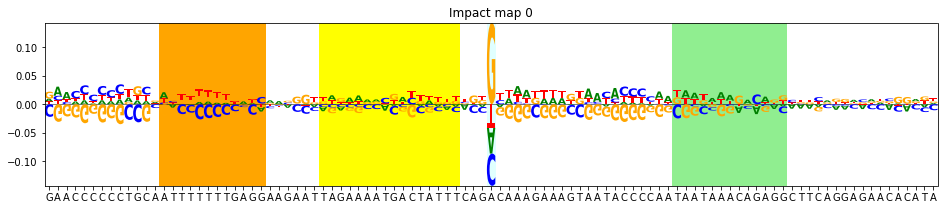

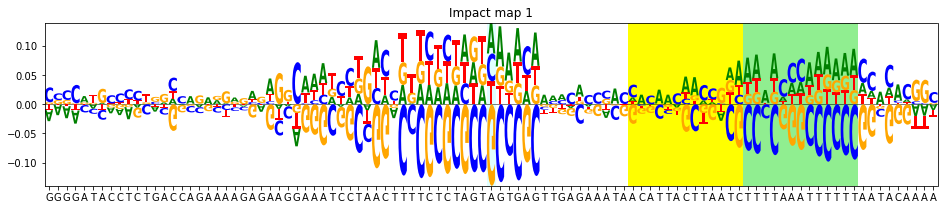

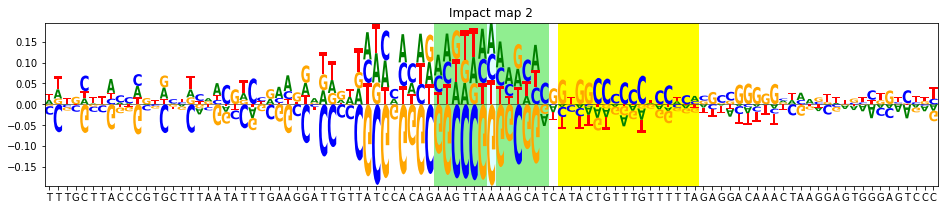

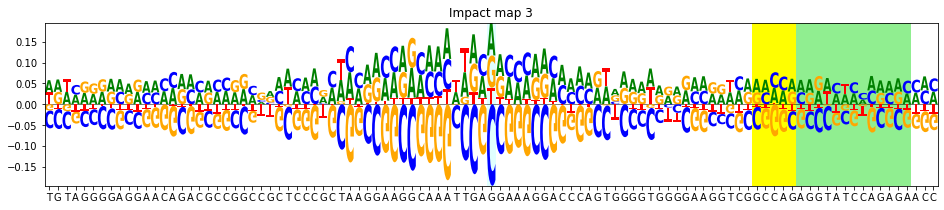

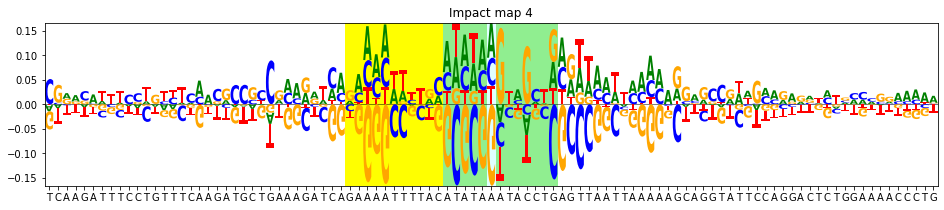

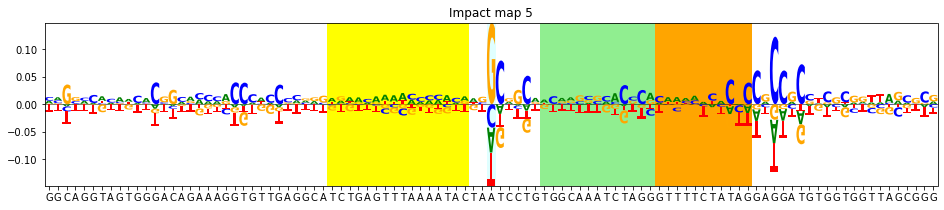

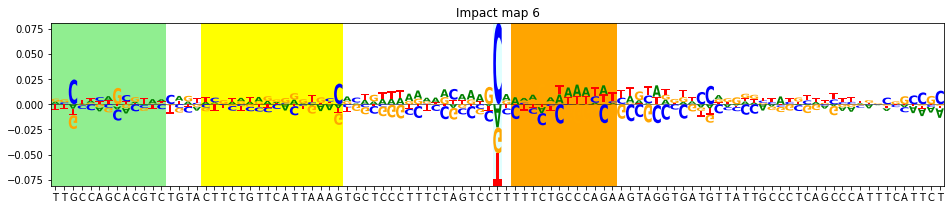

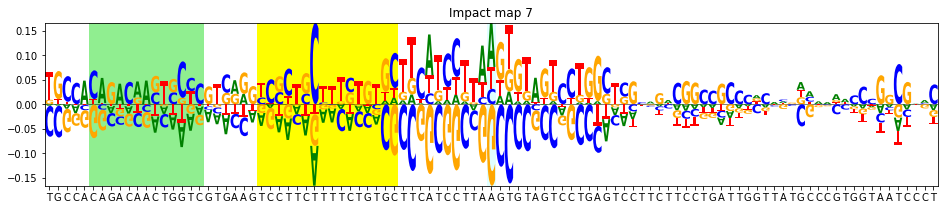

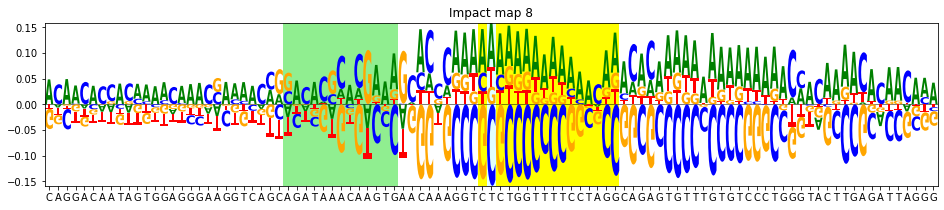

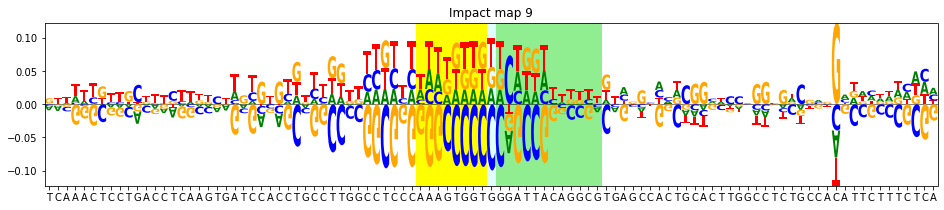

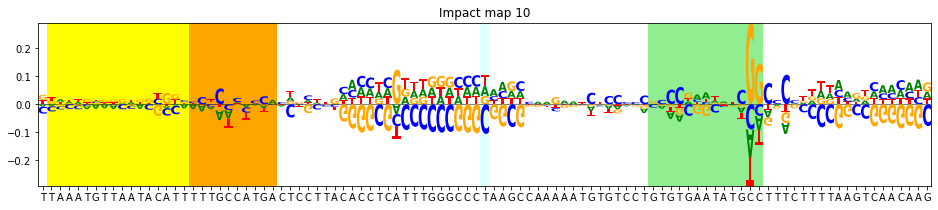

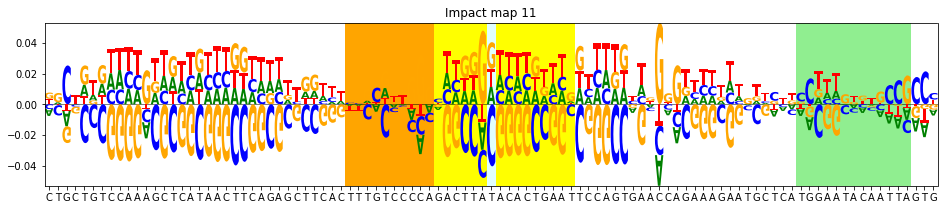

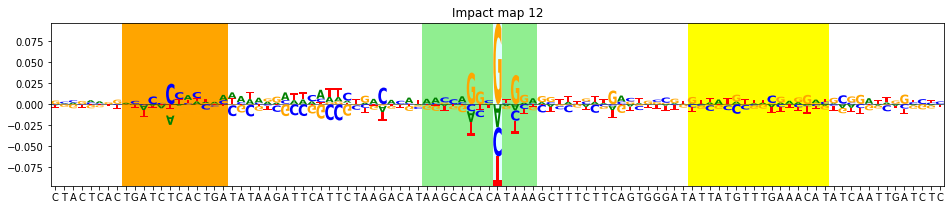

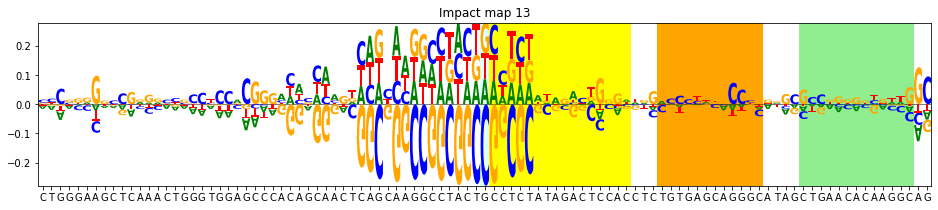

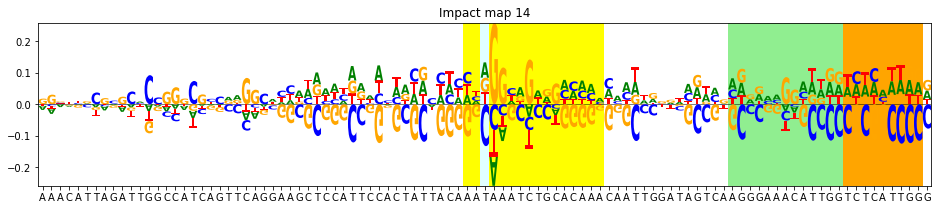

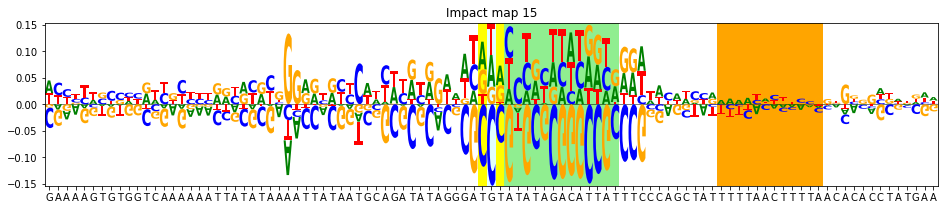

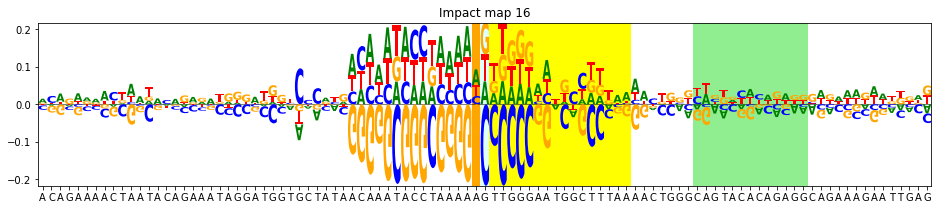

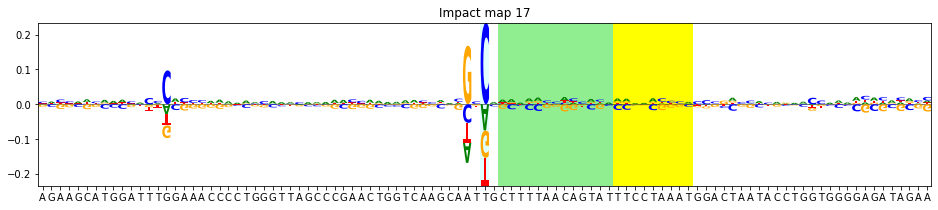

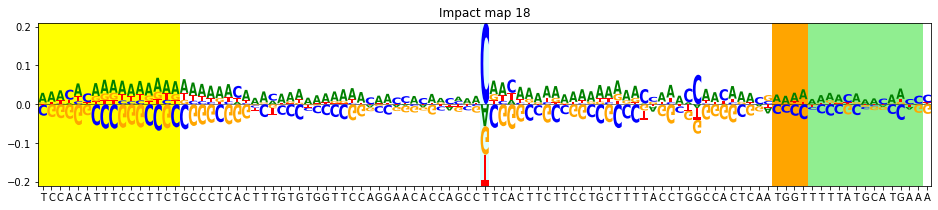

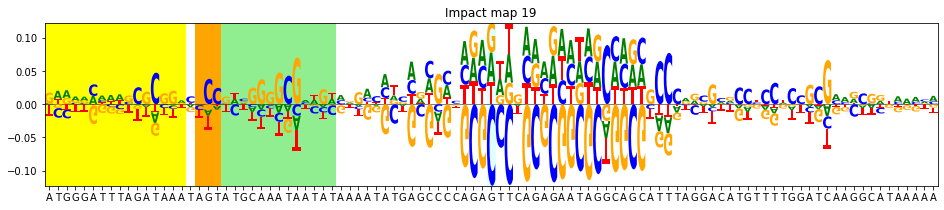

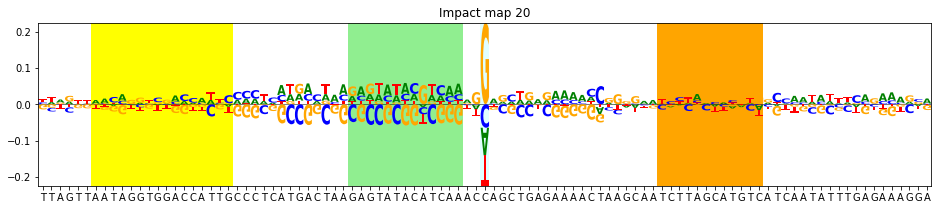

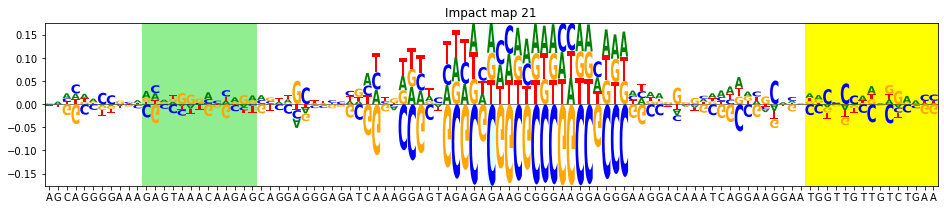

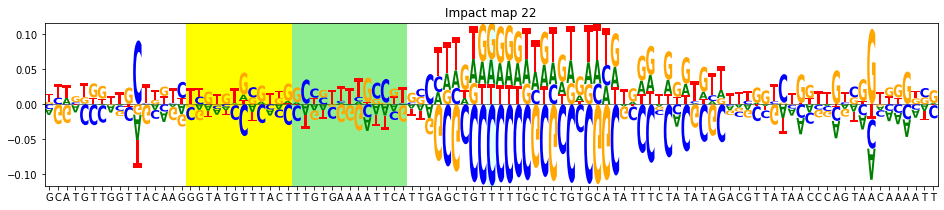

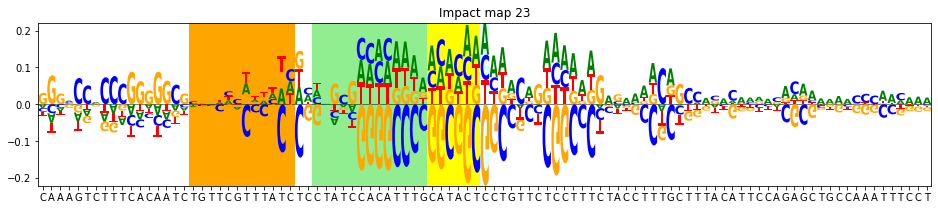

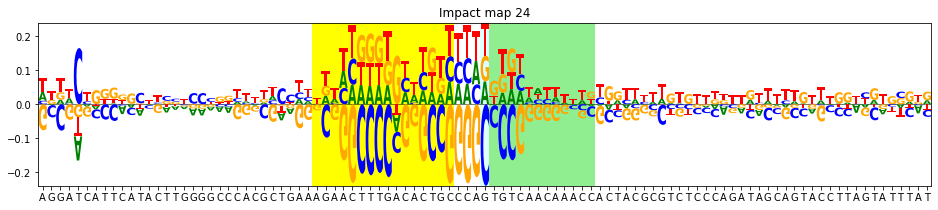

In [52]:
# context_size = 50
# for i, pwm in enumerate(foxa1_pwms):
#     fig, ax = plt.subplots(1, 1, figsize=[16, 3])
#     pwm_probs = (np.exp(pwm) - .1)
#     pwm_bits = - np.log2(pwm_probs / .25)
# #     print(pwm_probs, pwm_bits)
#     logo = Logo(pd.DataFrame(pwm_bits.T, columns=BASES), ax=ax)
#     logo.ax.set_title("PWM %d" % i)
#     logo.ax.set_ylim([0, 2])

pwm_colors = ['orange', 'orange', 'yellow', 'lightgreen']
    
for i, impact_map in enumerate(impact_maps[:25]):
    fig, ax = plt.subplots(1, 1, figsize=[16, 3])
    max_pos = np.argmin(np.min(impact_map, axis=0))
    start_idx, end_idx = max(0, max_pos - context_size), min(impact_map.shape[1], max_pos + context_size + 1)
    df = pd.DataFrame(impact_map.T, columns=BASES)
    logo = Logo(df.iloc[start_idx: end_idx], ax=ax)
    logo.ax.set_xticks(range(start_idx, end_idx))
    highlight_pos = int(start_idx + context_size if start_idx > 0 else end_idx - context_size - 1)
    
    for j, pwm in enumerate(foxa1_pwms):
        score = pwm_scores(np.expand_dims(pwm, 0), np.expand_dims(seqs[i, :, start_idx: end_idx], 0))
        pwm_match_pos = int(np.argmax(score[0]) + start_idx)
        logo.highlight_position_range(
            pmin=pwm_match_pos, pmax=pwm_match_pos + pwm.shape[1], color=pwm_colors[j]
        )
    
    logo.highlight_position_range(pmin=highlight_pos, pmax=highlight_pos, color='lightcyan')
    logo.ax.set_xticklabels('%s'% nt for nt in one_hot_decode(seqs[i])[start_idx: end_idx])
    logo.ax.set_title("Impact map %d" % i)